<a href="https://colab.research.google.com/github/juniperlovato/DiverseMisinformationPaper/blob/main/Final_Visualizations_of_Bootstrapping_confusion_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook generates bootstrap samples from two confusions matrices and compares their MCC scores. We use it to test the significance of biases in results of Lovato et al. (2022).

##Imports and installs

In [1]:
import numpy as np
import scipy
from scipy.stats import spearmanr
from scipy.stats import ttest_ind

In [2]:
#for latex in matpliotlib
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpotrace0 libptexenc1 libruby2.5 libsynctex1
  libtexlua52 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb poppler-data
  preview-latex-style rake ruby ruby-did-you-mean ruby-minitest
  ruby-net-telnet ruby-power-assert ruby-test-unit ruby2.5
  rubygems-integration t1utils tex-common tex-gyre texlive-base
  texlive-binaries texlive-fonts-recommended texlive-latex-base
  texlive-pictures texlive-plain-generic tipa
Suggested packages:
  fonts-noto ghostscript-x apach

##Functions for bootstraping and difference of mean test

In [3]:
#function that generates a bootstraped sampled of correlation coefficients
#input: confusion matrix as 4 parameters
#output an array of 10,000 correlation coefficient
def generate_corrcoeff(TP,FN,FP,TN):
  norm = TP+FN+FP+TN
  corrcoeff = []
  for repetition in range(10000):
    a = []
    b = []
    for data in range(norm):
      rn = np.random.randint(norm)
      if rn<TP:
        a.append(1)
        b.append(1)
      elif rn<TP+FN:
        a.append(0)
        b.append(1)
      elif rn<TP+FN+FP:
        a.append(1)
        b.append(0)
      else:
        a.append(0)
        b.append(0)
    corrcoeff.append(scipy.stats.spearmanr(a,b)[0])
  return corrcoeff

In [60]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

def find_confidence(array):
  array_has_nan = np.isnan(np.sum(array))
  if array_has_nan:
    return(np.sum(array))
  for quant in np.arange(0.000,1.0,0.001):
    res = np.quantile(array, quant)
    if res>0:
      return(quant - 0.001)
      break
  return(quant)


def complete_visualization(array1,label1,array2,label2,label3,label,ymax,deltax):

  xmin = -deltax
  xmax = deltax
  
  #subtract correlation coefficients from one another
  array = np.subtract(array1,array2)

  #calculate where 0 falls in the resulting quantiles
  confidence = find_confidence(array)
  #express confidence as a "probability" that the null can be rejected
  if confidence<0.5:
    confidence = 1-confidence

  #fix confidence format
  conf_str = f'{confidence:.2f}'
  if conf_str == '1.00':
    conf_str = '0.99'

  plt.rcParams['text.usetex']       = True
  plt.rcParams['font.size']         = 14
  plt.rcParams['font.family']       = 'serif'
  plt.rcParams['font.serif']        = 'Computer Modern Roman'
  plt.rcParams['xtick.major.width'] = 2
  plt.rcParams['xtick.major.size']  = 8
  plt.rcParams['ytick.major.width'] = 2
  plt.rcParams['ytick.major.size']  = 8

  #fit distributions
  (mean1, sigma1) = (np.mean(array1), np.std(array1))
  (mean2, sigma2) = (np.mean(array2), np.std(array2))
  (mean, sigma) = (np.mean(array), np.std(array))
  x = np.linspace(-1, 1, 1000)
  y1 = len(array1) * 0.02 * (1/np.sqrt(2*3.1416*sigma1**2))*np.exp(-0.5*(x-mean1)**2/sigma1**2)
  y2 = len(array2) * 0.02 *(1/np.sqrt(2*3.1416*sigma2**2))*np.exp(-0.5*(x-mean2)**2/sigma2**2)
  y = len(array) * 0.02 *(1/np.sqrt(2*3.1416*sigma**2))*np.exp(-0.5*(x-mean)**2/sigma**2)

  plt.plot(x,y1,c='blue', label=label1, linestyle='dotted')
  plt.plot(x,y2,c='orange', label=label2, linestyle='dashed')
  plt.plot(x,y,c='black', label=label3, linewidth=3)
  plt.legend(loc='upper left', frameon=False)
  plt.xlabel(r'MCC Scores')
  plt.ylabel(r'Bootstrap counts')

  plt.text(xmin+0.03,0.6*ymax,'credibility = %s'%(conf_str))
  plt.text(0.3*xmax,0.9*ymax,label)
  plt.ylim(0,ymax)
  plt.xlim(xmin,xmax)
  plt.savefig('fig.pdf')
  plt.show()

Generate and compare bootstrap samples for two *independent* categories to be compared

In [5]:
# White_Heterophily	"[[495 184]
#   [421 124]]"
# White_Homophily	"[[489 159]
#   [513 211]]"

#Argument key: TP,FN,FP,TN
bootstrap_homoW = generate_corrcoeff(489,159,513,211)
bootstrap_heteroW = generate_corrcoeff(495,184,421,124)

result_bias_W = ttest_ind(bootstrap_homoW,bootstrap_heteroW,equal_var=False)
print(result_bias_W)

Ttest_indResult(statistic=261.1865642508449, pvalue=0.0)


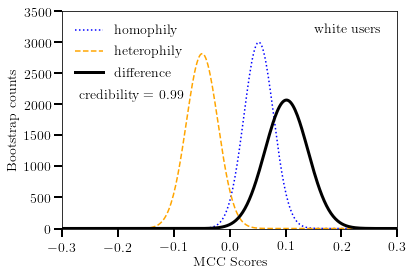

In [6]:
complete_visualization(bootstrap_homoW,'homophily',bootstrap_heteroW,'heterophily','difference','white users',3500,0.3)

In [8]:
#Argument key: TP,FN,FP,TN
#Male and female participants watching male videos

bootstrap_Male = generate_corrcoeff(355,320,105,138)
bootstrap_Female = generate_corrcoeff(243,246,99,96)

result_bias_Gender = ttest_ind(bootstrap_Male,bootstrap_Female,equal_var=False)
print(result_bias_Gender)

Ttest_indResult(statistic=185.7386290803315, pvalue=0.0)


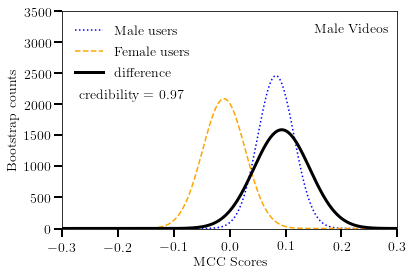

In [10]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_Male,'Male users',bootstrap_Female,'Female users', 'difference', 'Male Videos', 3500,0.3)

In [13]:
#Male and female viewers of POC videos

bootstrap_Male = generate_corrcoeff(427,334,127,118)
bootstrap_Female = generate_corrcoeff(341,298,121,85)

result_bias_Gender = ttest_ind(bootstrap_Male,bootstrap_Female,equal_var=False)
print(result_bias_Gender)


Ttest_indResult(statistic=180.04819089609683, pvalue=0.0)


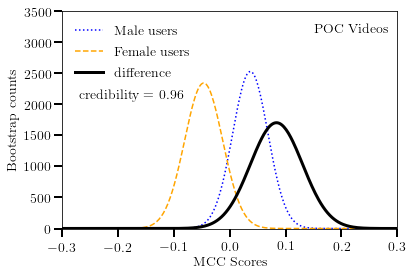

In [14]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_Male,'Male users',bootstrap_Female,'Female users', 'difference', 'POC Videos', 3500,0.3)


In [15]:
#Male and female viewers of white videos

bootstrap_Male = generate_corrcoeff(409,415,115,179)
bootstrap_Female = generate_corrcoeff(304,344,127,155)

result_bias_Gender = ttest_ind(bootstrap_Male,bootstrap_Female,equal_var=False)
print(result_bias_Gender)


Ttest_indResult(statistic=173.37676373414024, pvalue=0.0)


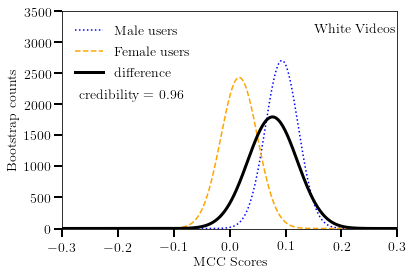

In [16]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_Male,'Male users',bootstrap_Female,'Female users', 'difference', 'White Videos', 3500,0.3)

In [17]:
#White and POC viewers of female videos

bootstrap_POC = generate_corrcoeff(330,289,92,127)
bootstrap_White = generate_corrcoeff(562,540,174,167)

result_bias_Gender = ttest_ind(bootstrap_POC,bootstrap_White,equal_var=False)
print(result_bias_Gender)

Ttest_indResult(statistic=231.49632301547737, pvalue=0.0)


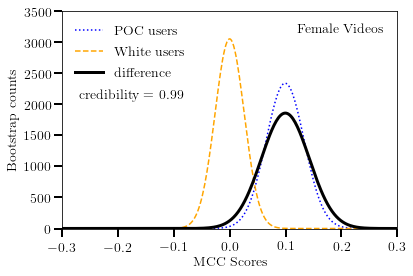

In [30]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_POC,'POC users',bootstrap_White,'White users', 'difference','Female Videos', 3500,0.3)


In [31]:
#Argument key: TP,FN,FP,TN
# # PersonofColor_with_POC_video "[[306 233]
#  [ 79  90]]"
# # White_with_POC_video "[[462 399]
#  [169 113]]"


bootstrap_White = generate_corrcoeff(462,399,169,113)
bootstrap_POC = generate_corrcoeff(306,233,79,90)

result_bias_race = ttest_ind(bootstrap_White,bootstrap_POC,equal_var=False)
print(result_bias_race)

Ttest_indResult(statistic=-291.66541115970267, pvalue=0.0)


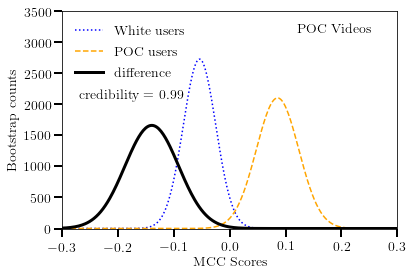

In [32]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_White,'White users',bootstrap_POC,'POC users', 'difference', 'POC Videos',3500,0.3)

In [33]:
#White and POC viewers of Old videos

bootstrap_POC = generate_corrcoeff(99,90,31,51)
bootstrap_White = generate_corrcoeff(187,160,68,59)

result_bias_Gender = ttest_ind(bootstrap_POC,bootstrap_White,equal_var=False)
print(result_bias_Gender)


Ttest_indResult(statistic=174.53266947809732, pvalue=0.0)


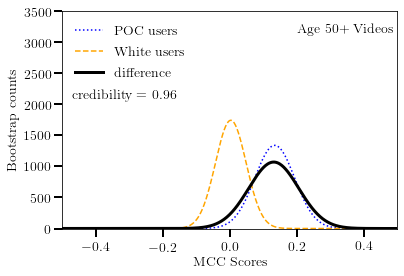

In [55]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_POC,'POC users',bootstrap_White,'White users',  'difference', 'Age 50+ Videos',3500,0.5)


In [36]:
#different age viewers of Female videos

bootstrap_Young = generate_corrcoeff(150,121,31,67)
bootstrap_Middle = generate_corrcoeff(239,244,63,62)
bootstrap_Old = generate_corrcoeff(503,464,172,165)


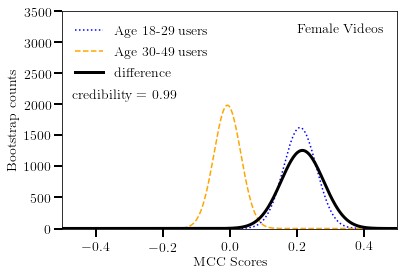

In [52]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_Young,'Age 18-29 users', bootstrap_Middle, 'Age 30-49 users', 'difference', 'Female Videos',3500,0.5)


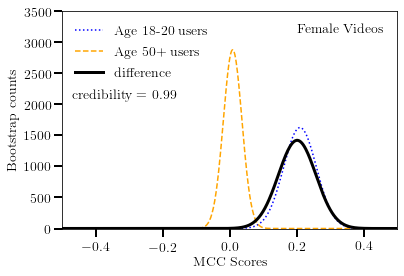

In [51]:
complete_visualization(bootstrap_Young, 'Age 18-20 users', bootstrap_Old, 'Age 50+ users',  'difference', 'Female Videos',3500,0.5)


In [ ]:
#different age viewers of young videos

bootstrap_Young = generate_corrcoeff(117,107,28,51)
bootstrap_Middle = generate_corrcoeff(106,99,28,31)
bootstrap_Old = generate_corrcoeff(239,270,91,94)


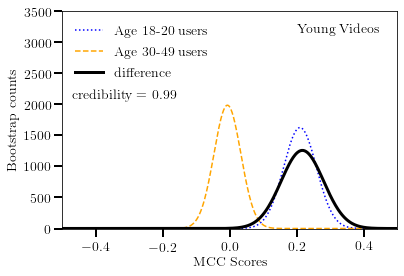

In [56]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_Young, 'Age 18-20 users', bootstrap_Middle, 'Age 30-49 users',  'difference', 'Young Videos',3500,0.5)

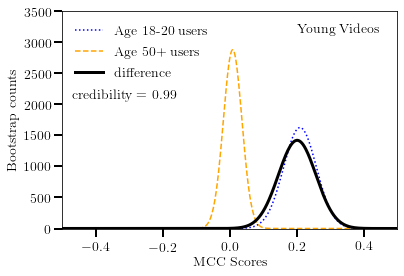

In [57]:
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_Young, 'Age 18-20 users', bootstrap_Old, 'Age 50+ users',  'difference', 'Young Videos',3500,0.5)

In [58]:
#different age viewers of middle-aged videos

bootstrap_Young = generate_corrcoeff(112,90,34,46)
bootstrap_Middle = generate_corrcoeff(235,243,64,65)
bootstrap_Old = generate_corrcoeff(435,363,161,155)


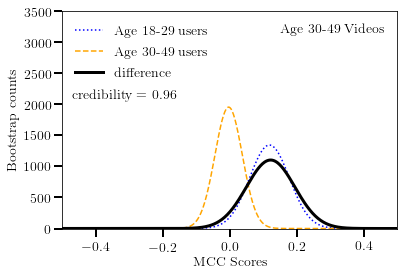

In [62]:
#Argument key:  array and label, demographic array
#Argument key:  array and label, demographic array
complete_visualization(bootstrap_Young, 'Age 18-29 users', bootstrap_Middle, 'Age 30-49 users', 'difference', 'Age 30-49 Videos',3500,0.5)
